# Introducing Scikit-Learn (ii)

In [ ]:
# Import a few basic required libraries here:
import numpy as np

Having completed a basic overview, we will now use Scikit-Learn to visualise  a few fundamental concepts in machine learning. These will include:
* Bias-variance trade-off
* Something else

Thereafter, we will move to a real-world example to give you the opportunity to conduct a mock data science problem yourself. There is no expectation on any particular scores your models might achieve, the only goal is that you get a feel for how one might approach an ML problem, and what tools exist to score your model.

### Bias-variance tradeoff

In [ ]:
...

# Example real-world problem

Machine learning is prevelant in today's scientific landscape, with applications spanning Biomedical engineering, astrostatistics, finance, the entertainment industry, and countless other disciplines. 

In this tutorial we will consider how one might use ML to classify acoustics into categories. This type of analysis involves:



1.   Data collection and pre-processing
2.   Feature generation
3.   Model selection
4.   Model training
5.   Analysing model performance

You will find in practice that the key to unlocking good predictive insights is the quality and quantity of data used. We will however not make this the focal point, and assume the data is clean within reason.

If you are interested in common difficulties encountered with data processing, please refer to [XYZ]



### Problem definition
#### Mosquito acoustic detection: can we use machine learning to detect mosquitoes from the sound of their acoustic wingbeat?

Mosquitoes are responsible over xyz yyz [cite]. As a byproduct of their behaviour patterns, they produce a characteristic buzz from their flight, mating calls, and other etc... The idea is to leverage this sound with cheap sensors (acoustic smartphone sensors in an IoT network) to be able to estimate the prevelance of mosquitoes in a particular area. To do this, we need algorithms capable of distinguishing the buzz of mosquito from its surroundings. In this challenge we will show how it is possible to use Scikit-learn to build a basic classifier to achieve this.

## 1. Data input processing 

By default, opening colab will place you in the following directory:

In [ ]:
import os
os.getcwd()

'/content'

We can now donwload the dataset of interest from the repository with `wget` and unzip to the subfolder `data`. The `!` before the command is used to run operating system commands directly in the notebook cell (in this case, which ever Linux OS the colab machines are using).

In [ ]:
!wget https://github.com/ikiskin/UNIQ-deepmind/raw/master/data/CulexMozzSounds.zip # Get audio files
!wget https://github.com/ikiskin/UNIQ-deepmind/raw/master/data/CulexUNIQ.csv -O data/CulexUNIQ.csv # Get labels and place in data subdir
!unzip /content/CulexMozzSounds.zip -d /content/data/ # unzip files to data subdir

--2022-06-29 22:53:59--  https://github.com/ikiskin/UNIQ-deepmind/raw/master/data/CulexMozzSounds.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ikiskin/UNIQ-deepmind/master/data/CulexMozzSounds.zip [following]
--2022-06-29 22:53:59--  https://raw.githubusercontent.com/ikiskin/UNIQ-deepmind/master/data/CulexMozzSounds.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28644396 (27M) [application/zip]
Saving to: ‘CulexMozzSounds.zip.1’

CulexMozzSounds.zip 100%[===================>]  27.32M  80.2MB/s    in 0.3s    

2022-06-29 22:53:59 (80.2 MB/s) - ‘CulexMozzSounds.zip.1’ saved [28644396/2

To start, we will split the recordings into a training and testing hold-out set. This is to ensure that we do not see parts of identical recordings in both training or testing

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('data/CulexUNIQ.csv')

In [ ]:
df.head()  # Display a few label entries

,id,fine_start_time,fine_end_time,path,name,sample_rate,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type
0,222691,0.0,53.760,/Culex/sounds/0001_norm.wav,0001_norm.wav,8000,background,NaN,NaN,NaN,NaN,NaN,NaN,phone,Alcatel,UK,Oxfordshire,NaN,Oxford Zoology,culture
1,222692,0.0,54.272,/Culex/sounds/0002_norm.wav,0002_norm.wav,8000,background,NaN,NaN,NaN,NaN,NaN,NaN,phone,Alcatel,UK,Oxfordshire,NaN,Oxford Zoology,culture
2,222693,0.0,54.272,/Culex/sounds/0003_norm.wav,0003_norm.wav,8000,background,NaN,NaN,NaN,NaN,NaN,NaN,phone,Alcatel,UK,Oxfordshire,NaN,Oxford Zoology,culture
3,222694,0.0,54.272,/Culex/sounds/0004_norm.wav,0004_norm.wav,8000,background,NaN,NaN,NaN,NaN,NaN,NaN,phone,Alcatel,UK,Oxfordshire,NaN,Oxford Zoology,culture
4,222695,0.0,54.272,/Culex/sounds/0005_norm.wav,0005_norm.wav,8000,background,NaN,NaN,NaN,NaN,NaN,NaN,phone,Alcatel,UK,Oxfordshire,NaN,Oxford Zoology,culture


## 2. Dataset creation
### Train/test definition

In [ ]:
train_list = []
test_list = []

for i in os.listdir('data/'):
  if i.endswith('.wav'): # Iterate over '.wav' files only
    if int(i[:4]) > 40:  # Reserve 17/57 recordings for testing
      test_list.append(i)
    else:
      train_list.append(i)

## 3. Data feature extraction and pre-processing


### Feature generation
In general, features extracted will vary from domain to domain, and we could opt to go for highly hand-crafted descriptors or let our inference models learn their own representations entirely. Current SOTA performance tends to use something in between, though this is highly dependent on the domain

For creating features we have several options to explore with audio:


1.   Learn hierarchical feature representations with neural networks from:
  1. Raw audio waveform
  2. Intermediate feature representations

2. Extract descriptive features. In audio these could be MFCCs -- a bandpass of non-linearly spaced frequency features, based on the mel-scale (melodic scale), where humans perceive each band as evenly spaced in blab bla bla [CITE + CORRECT]. There are many features we could go for, such as zero crossing rate, spectral power, fluctuations in xyz - for a complete list you could refer to OpenSMILE. 

2.   List item


2.   List item




We now have the raw data accessible as files for train and for test, and corresponding label information in `csv` format. We now need to map this data into a form that can be used to perform computations with scikit-learn

In [ ]:
import librosa

In [ ]:
def get_feat(data_list):

  label_list = []  # Initialise empty label list
  feature_list = [] # Initialise empty signal list

  for i in data_list:  # Iterate through each file in list

    # Extract corresponding label(s) in dataframe
    df_match = df[df.name == i]

    for idx, row in df_match.iterrows():
      print(i, row.fine_end_time, row.fine_start_time, row.sound_type)
      # Load the audio sections marked with a specific label
      signal, sr = librosa.load(os.path.join('data', i), sr=None, offset=row.fine_start_time,
                          duration=row.fine_end_time-row.fine_start_time)
      ### Extract features here:

      # For this example we will use default settings of MFCC features:
      x = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=20)

      feature_list.append(x)

      if row.sound_type == 'mosquito':
        label_list.append(np.ones(np.shape(x)[1]))
      elif row.sound_type == 'background':
        label_list.append(np.zeros(np.shape(x)[1]))
      else:
        print('Warning: label not recognised.')

  # We now have two lists of equal length (L), determined by the number of labels
  # in the dataframe. Each element of the signal_list will be 
  # of the length equal to the number of feature windows N_f

  print('Length of label and signal lists:', len(label_list), len(feature_list))


  X = np.hstack(feature_list).T # Transpose required for shape for sklearn
  y = np.hstack(label_list)

  print('X shape, y shape', np.shape(X), np.shape(y))
  return X, y

In [66]:
X_train, y_train = get_feat(train_list)

0003_norm.wav 54.272 0.0 background
0020_norm.wav 54.272 0.0 background
0030_norm.wav 37.6 22.2 mosquito
0030_norm.wav 54.272 52.7 background
0030_norm.wav 21.8 12.6 mosquito
0030_norm.wav 12.6 0.0 background
0030_norm.wav 22.2 21.8 background
0030_norm.wav 38.9 37.6 background
0030_norm.wav 52.7 50.7 mosquito
0030_norm.wav 43.3 38.9 mosquito
0030_norm.wav 50.7 43.3 background
0025_norm.wav 10.24 0.0 background
0039_norm.wav 5.3 0.0 mosquito
0039_norm.wav 54.272 46.7 mosquito
0039_norm.wav 46.7 5.3 background
0017_norm.wav 54.272 0.0 background
0012_norm.wav 54.272 0.0 background
0016_norm.wav 54.272 0.0 background
0002_norm.wav 54.272 0.0 background
0021_norm.wav 0.9 0.0 background
0021_norm.wav 45.7 32.7 background
0021_norm.wav 59.392 45.7 mosquito
0021_norm.wav 32.7 0.9 mosquito
0001_norm.wav 53.76 0.0 background
0004_norm.wav 54.272 0.0 background
0014_norm.wav 54.272 0.0 background
0034_norm.wav 51.3 43.5 mosquito
0034_norm.wav 3.7 0.0 mosquito
0034_norm.wav 54.272 51.3 backgroun

In [67]:
X_test, y_test = get_feat(test_list)

0053_norm.wav 46.3 0.0 mosquito
0043_norm.wav 54.272 0.0 background
0044_norm.wav 16.64 0.0 background
0049_norm.wav 47.1 0.0 background
0049_norm.wav 54.2 47.1 mosquito
0057_norm.wav 39.68 1.9 background
0057_norm.wav 0.5 0.0 background
0057_norm.wav 1.9 0.5 mosquito
0050_norm.wav 26.4 9.7 background
0050_norm.wav 41.4 33.6 background
0050_norm.wav 54.2 41.4 mosquito
0050_norm.wav 33.6 26.4 mosquito
0050_norm.wav 9.7 0.0 mosquito
0045_norm.wav 59.6 14.5 mosquito
0045_norm.wav 14.5 0.0 background
0054_norm.wav 54.272 0.0 background
0055_norm.wav 24.511 20.9 mosquito
0055_norm.wav 44.5 35.2 mosquito
0042_norm.wav 59.648 0.0 background
0041_norm.wav 58.112 0.0 background
0051_norm.wav 53.4 31.1 mosquito
0051_norm.wav 8.0 0.0 mosquito
0051_norm.wav 13.2 12.0 mosquito
0052_norm.wav 33.8 27.6 mosquito
0052_norm.wav 54.272 33.8 background
0052_norm.wav 27.6 0.0 background
0056_norm.wav 24.832 20.0 background
0056_norm.wav 19.9 0.0 mosquito
0048_norm.wav 54.2 0.1 mosquito
0046_norm.wav 54.272

### Pre-processing

Pre-process by removing the mean and standard deviation. We will store the results in xyz to then apply to the test data. Note that there are several schemes for normalisation:

* Normalise per sample/recording. This is similar to how images will be normalised by their intensity relative to only themselves
* As above, but normalise in batches [read more about this]
* Use the entire dataset to remove offset statistics such as the mean, and standardise the variance. When predicting over test data, we perform the same transform to the test data.

There is no universal or accepted method of normalising audio data, as there are benefits and drawbacks to each. You may experiment with different schemes. However, it is important to consider that some ML algorithms are expected to operate in a certain range, and require re-scaling to appropriate units. An example of this is the SVM because XYZ


In [54]:
np.shape(X_train)

(33436, 20)

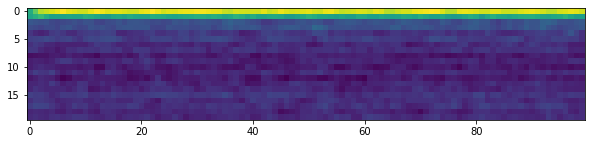

In [68]:
plt.figure(figsize=(10,10))
plt.imshow(X_train[:100,:].T)

In [56]:
# X_train = X_train[:,3:]

In [57]:
# X_test = X_test[:,3:]

In [69]:
normalise = True

mean = np.mean(X_train)
std = np.std(X_train)

if normalise:
  X_train_norm = (X_train - mean)/std

## 4. Model instantiation and prediction

In [71]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


clf = svm.SVC()
# clf = RandomForestClassifier(max_depth=5, random_state=0)
# clf = GaussianNB()

if normalise:
  clf.fit(X_train_norm, y_train)  # transform array X to required format
else:
  clf.fit(X_train, y_train)

In [72]:
if normalise:
  y_pred = clf.predict((X_test - mean)/std) # Predict over normalised data
else:
  y_pred = clf.predict(X_test) # Predict over un-normalised data

## 5. Model performance
### A re-cap from day 1:


*   List item
*   List item

To also note: be careful with accuracy scores: in the presence of a class imbalance such as here (see the support of each class, 8272 of class 0 and 3979 of class 1), a high accuracy can be achieved by a model which simply predicts 0. This however would be reflected in very poor precision and recall scores for that class from the classification report.

Note that in this problem, we have extracted feature windows of a certain width, determined by xxx, which means that our performance figures here are given as performance per unit of time of each feature window.

Accuracy score 0.6253367072075748
              precision    recall  f1-score   support

non-mosquito       0.80      0.60      0.68      8272
    mosquito       0.45      0.68      0.54      3979

    accuracy                           0.63     12251
   macro avg       0.62      0.64      0.61     12251
weighted avg       0.68      0.63      0.64     12251



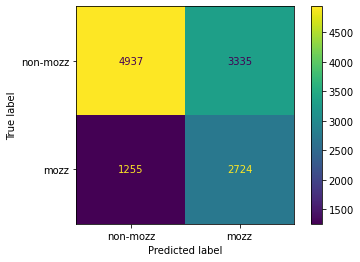

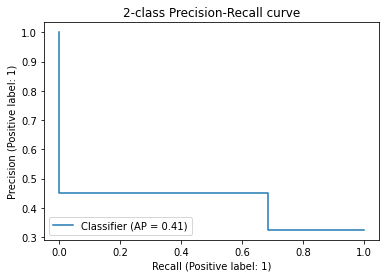

In [73]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

print('Accuracy score', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['non-mosquito', 'mosquito']))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['non-mozz','mozz'])

plt.show()

display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="Classifier")
_ = display.ax_.set_title("2-class Precision-Recall curve")